只使用close预测
找到最佳参数

In [16]:
import os
while os.getcwd().split('\\')[-1] != "Data_Analyst_FJNU":
    os.chdir('..')
print(os.getcwd())

e:\Desktop\学业\第五学期课业\数据分析\Data_Analyst_FJNU


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [18]:
def get_stock_data(code):
    stock_data =  pd.read_csv(f'./Data/history_A_stock_k_data/{code}.csv')
    stock_data = stock_data[['date','close']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data.set_index('date',inplace=True)
    return stock_data

def plot_dataframe(df):
    plt.plot(df.index, df['close'])
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title('DataFrame Plot')
    plt.show()
    
def create_sequences(data, sequence_length):
    X, y, indices = [], [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length])
        y.append(data.iloc[i+sequence_length])
        indices.append(data.index[i+sequence_length])
    return np.array(X), np.array(y), indices

def create_seq(dataset,dimension):
    train_size = round(len(dataset) * 0.80)
    train_seq = []
    train_label = []
    test_seq = []
    test_label = []
    start_idx = 0
    for stop_idx in range(dimension,train_size):
        train_seq.append(dataset[start_idx:stop_idx])
        train_label.append(dataset[stop_idx])
        start_idx += 1
    for stop_idx in range(train_size,len(dataset)):
        test_seq.append(dataset[start_idx:stop_idx])
        test_label.append(dataset[stop_idx])
        start_idx += 1
    train_seq, train_label, test_seq, test_label = np.array(train_seq),np.array(train_label),np.array(test_seq),np.array(test_label)    
    print("原始数据形状：", dataset.shape)
    print("训练数据形状：", train_seq.shape)
    print("训练标签形状：", train_label.shape)
    print("测试数据形状：", test_seq.shape)
    print("测试标签形状：", test_label.shape)
    return train_seq, train_label, test_seq, test_label
def build_model(units, LSTM_layers, Dense_layers, X_train, y_train):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.1))
    
    for _ in range(LSTM_layers):
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(0.1))
    
    model.add(LSTM(units=units))
    model.add(Dropout(0.1))
    
    for _ in range(Dense_layers):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(0.1))
    
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()

    return model


In [19]:
df = get_stock_data('sh.600010')
df.tail()

,close
date,
2023-12-20,1.39
2023-12-21,1.41
2023-12-22,1.42
2023-12-25,1.43
2023-12-26,1.41


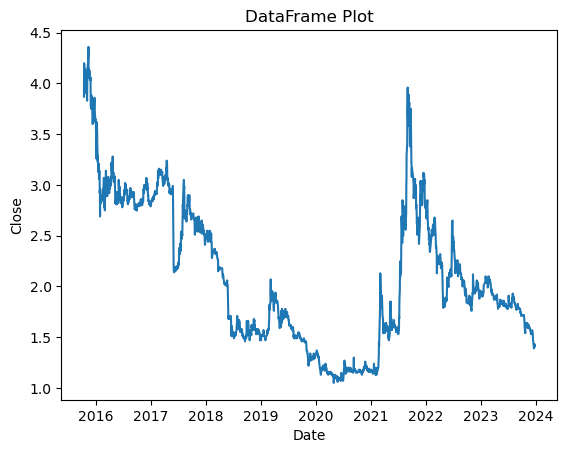

In [20]:
plot_dataframe(df)

In [21]:
dimension = 50
# 创建样本-标签对和索引
X, y, indices = create_sequences(df['close'], dimension)

# 归一化处理
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

# 随机切分
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size=0.2, random_state=42, shuffle=False)

# 尾切分
# split_index = int(len(df) * 0.8)
# X_train = X[:split_index]
# X_test = X[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index:]
# train_indices = indices[:split_index]
# test_indices = indices[split_index:]
# train_data, test_data = df.iloc[:split_index], df.iloc[split_index:]

# 输出训练集和测试集的形状
print("原始数据集形状:", df.shape)
print("原始输入集形状:", X.shape)
print("原始输出集形状:", y.shape)
print("训练集输入形状:", X_train.shape)
print("训练集输出形状:", y_train.shape)
print("测试集输入形状:", X_test.shape)
print("测试集输出形状:", y_test.shape)

原始数据集形状: (2000, 1)
原始输入集形状: (1950, 50)
原始输出集形状: (1950, 1)
训练集输入形状: (1560, 50)
训练集输出形状: (1560, 1)
测试集输入形状: (390, 50)
测试集输出形状: (390, 1)


In [22]:
units = 64
LSTM_layers = 1
Dense_layers = 1
# 构建模型
model = build_model(units, LSTM_layers, Dense_layers,X_train, y_train)
# 添加早停法
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# 训练模型
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
# 训练模型

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 64)            16896     
                                                                 
 dropout_4 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

13/13 [==============================] - 0s 24ms/step - loss: 2.9170e-04 - mean_absolute_error: 0.0119
Test Loss: 0.00029170484049245715, Test Mean Absolute Error: 0.011925671249628067


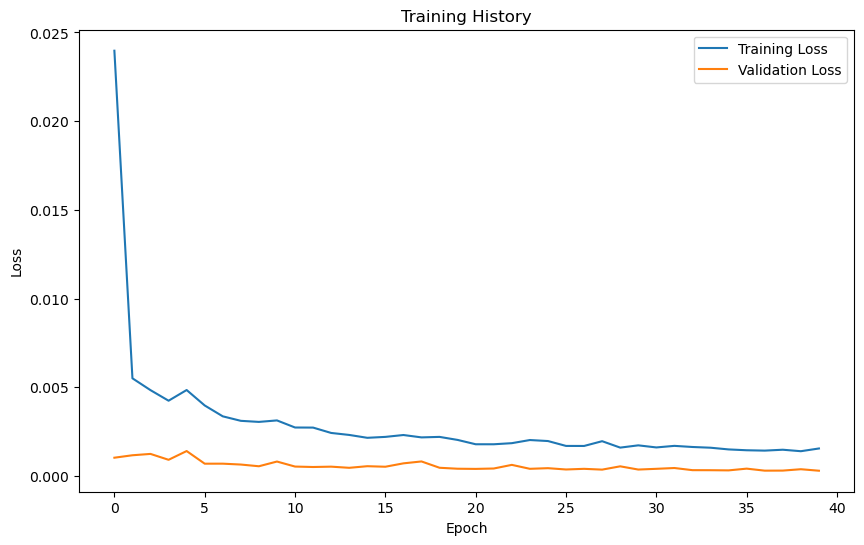

In [23]:
def evaludate(model,X,y):
    loss, mean_absolute_error = model.evaluate(X,y)
    print(f'Test Loss: {loss}, Test Mean Absolute Error: {mean_absolute_error}')
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
evaludate(model,X_test,y_test)

13/13 [==============================] - 1s 15ms/step


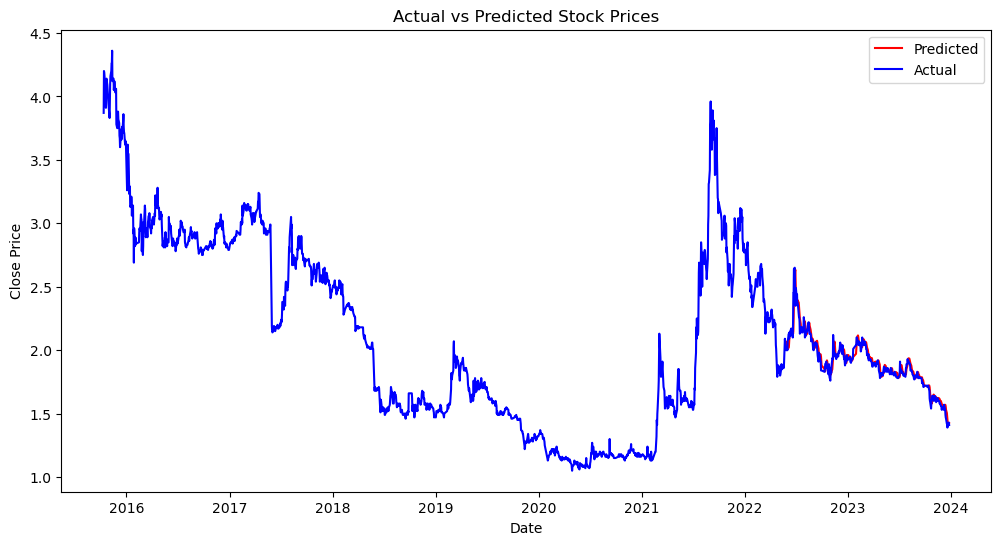

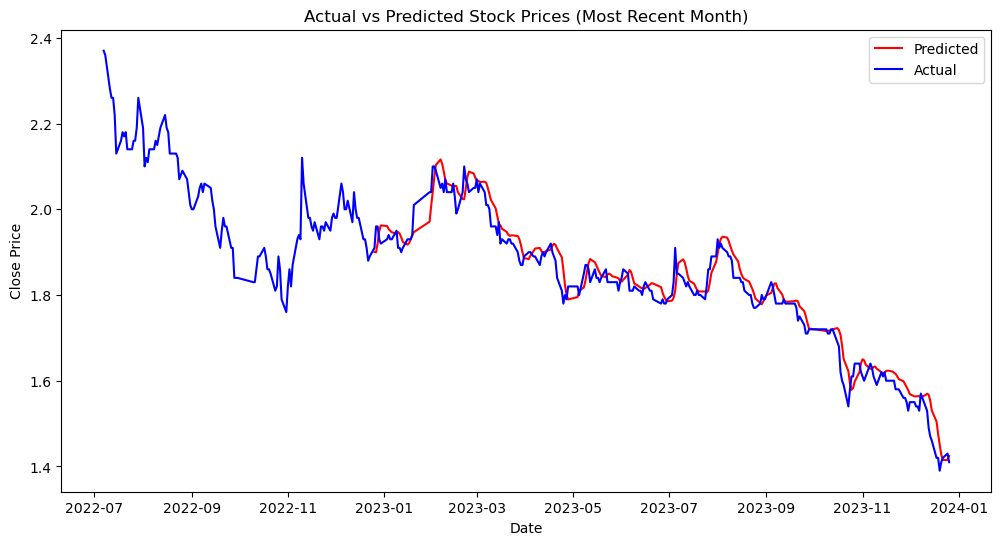

            Predicted
Date                 
2023-12-20   1.450888
2023-12-21   1.427990
2023-12-22   1.415168
2023-12-25   1.414868
2023-12-26   1.424591


In [24]:
def predict_show(X_test, indices):
    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred)

    result_df = pd.DataFrame({'Date': indices, 'Predicted': y_pred_actual.flatten()})
    result_df.index = pd.to_datetime(result_df.index)
    result_df.set_index('Date', inplace=True)
    result_df.sort_index(inplace=True)

    # plot
    # scatter

    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df['Predicted'], label='Predicted', color='red')
    plt.plot(df.index, df['close'], label='Actual', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.legend()
    plt.show()


    recent_month_data = result_df[result_df.index >= result_df.index.max() - pd.DateOffset(months=12)]
    plt.figure(figsize=(12, 6))
    plt.plot(recent_month_data.index, recent_month_data['Predicted'], label='Predicted', color='red')
    plt.plot(df.index[-30*12:], df['close'].tail(30*12), label='Actual', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Stock Prices (Most Recent Month)')
    plt.legend()
    plt.show()

    print(result_df.tail(5))
predict_show(X_test, test_indices)

In [25]:
X_test.shape

(390, 50)

In [26]:
X[-40:].shape

(40, 50)

 6/35 [====>.........................] - ETA: 0s

35/35 [==============================] - 1s 23ms/step


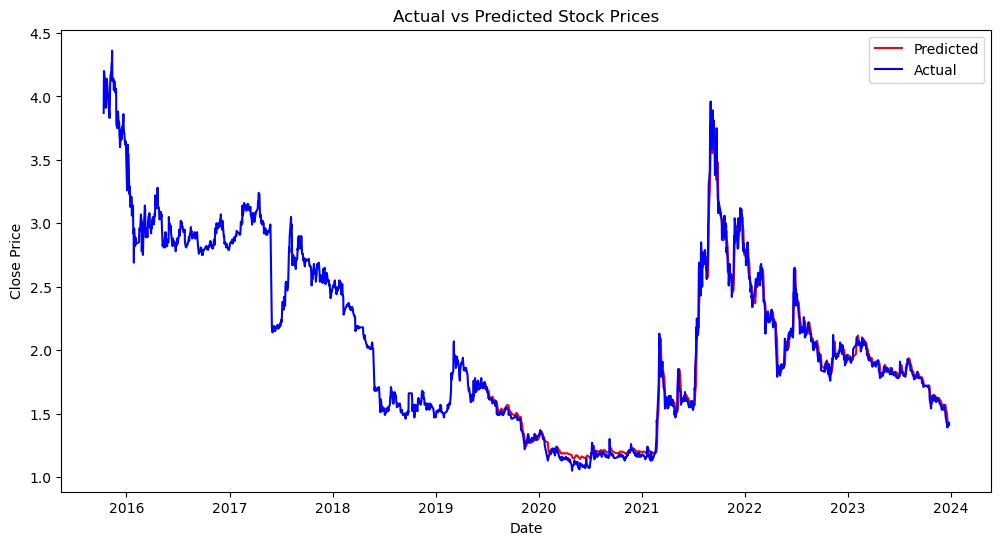

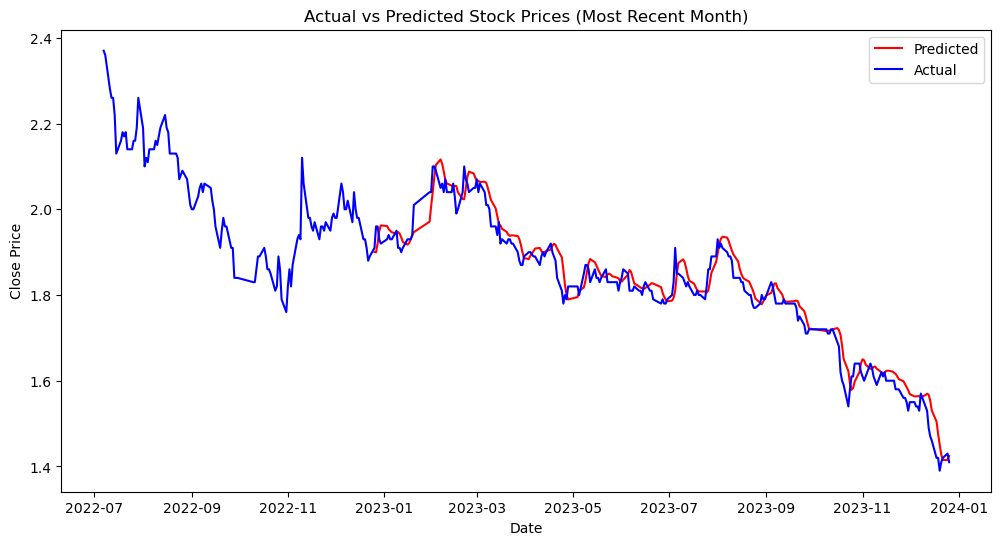

            Predicted
Date                 
2023-12-20   1.450888
2023-12-21   1.427990
2023-12-22   1.415168
2023-12-25   1.414868
2023-12-26   1.424591


In [27]:
predict_show(X[-1098:],df.index[-1098:])

61/61 [==============================] - 1s 20ms/step


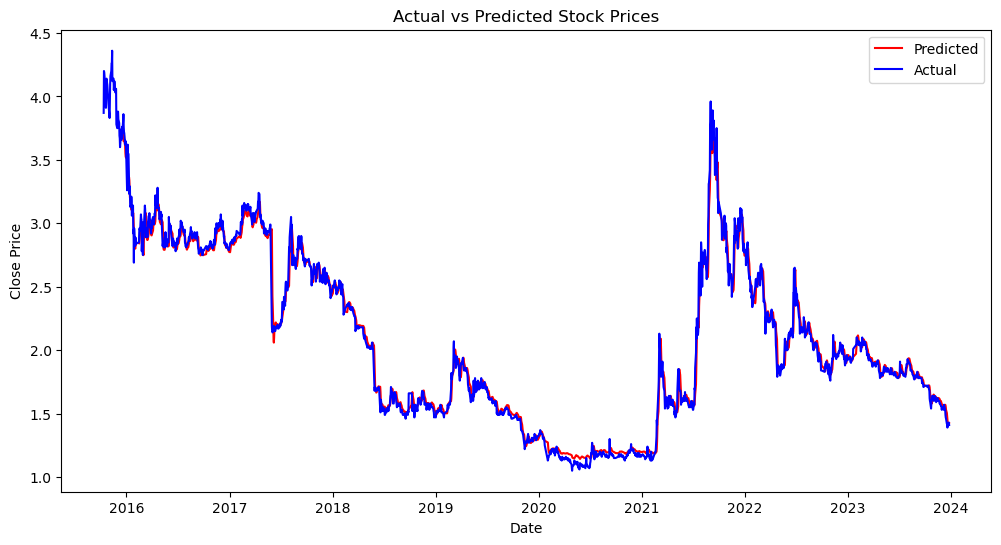

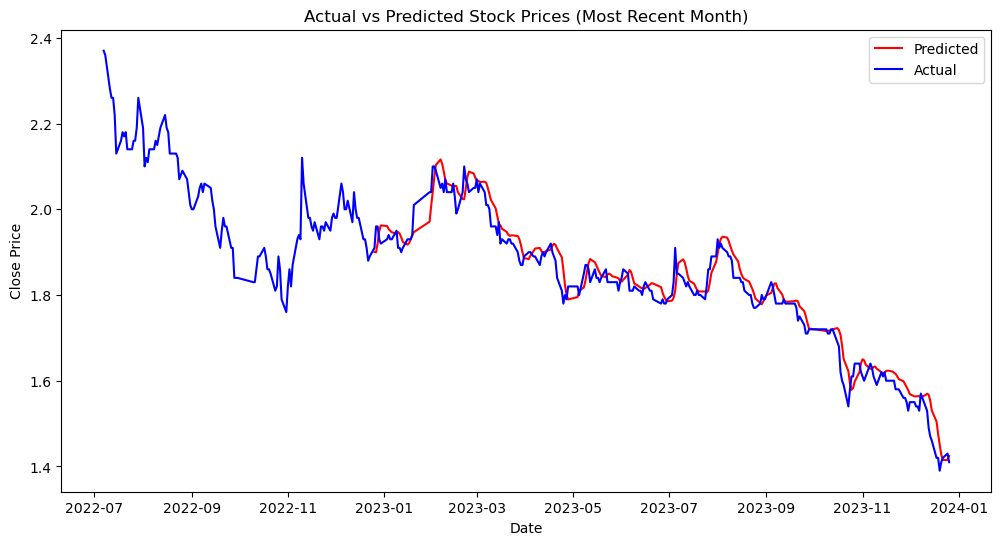

            Predicted
Date                 
2023-12-20   1.450888
2023-12-21   1.427990
2023-12-22   1.415168
2023-12-25   1.414868
2023-12-26   1.424591


In [28]:
predict_show(X,df.index[dimension:])

1/1 [==============================] - 0s 41ms/step


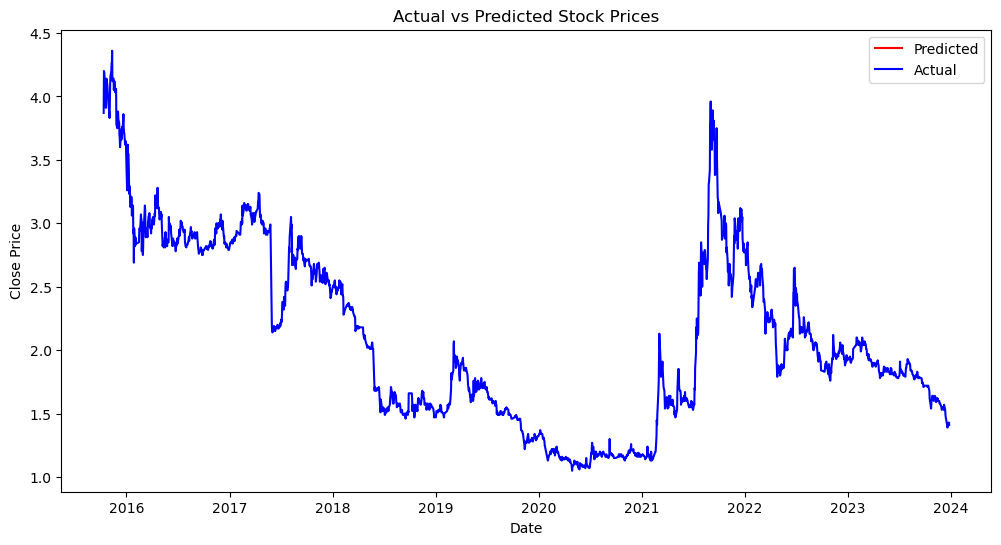

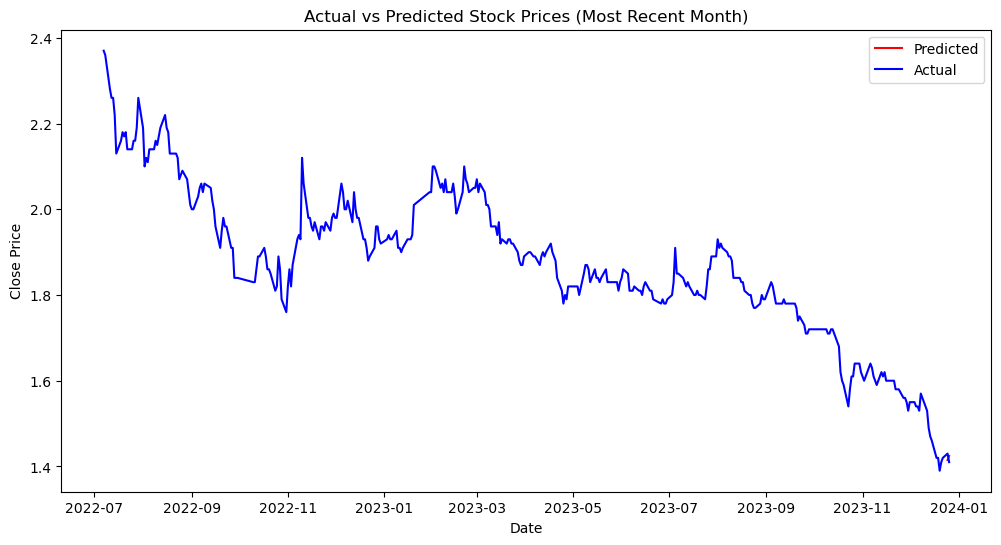

            Predicted
Date                 
2023-12-25   1.414869
2023-12-26   1.424591


In [29]:
predict_show(X[-2:],df.index[-2:])

In [30]:
def predict_next(model, df):
    last_sequence = df.iloc[-dimension:].values
    last_sequence = scaler.transform(last_sequence)
    last_sequence = last_sequence.transpose()
    predicted_value = model.predict(last_sequence)
    predicted_value = scaler.inverse_transform(predicted_value)
    last_date = df.index[-1]
    result_data = {'close': predicted_value[0]}
    result_date = last_date + pd.DateOffset(days=1)
    result_df = pd.DataFrame(result_data, index=[result_date])
    new_df = pd.concat([df, result_df], axis=0)
    return new_df
new_df = df
new_df = predict_next(model, new_df)
new_df = predict_next(model, new_df)
new_df = predict_next(model, new_df)
new_df = predict_next(model, new_df)
new_df.tail()

1/1 [==============================] - 0s 26ms/step


,close
2023-12-26,1.410000
2023-12-27,1.432310
2023-12-28,1.440762
2023-12-29,1.450203
2023-12-30,1.460353
